In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
pal = sns.color_palette()

In [2]:
sparse_predictors = ["age_group", "male", "anc_cat", "facdelivery", "hh_urban", "v024"] #administrative data
contextual_predictors = ["nightlights_composite", "un_population_cat", "travel_times_2015"] #custer level data from censor
additional_predictors = ["birth_order", "mum_educlow", "mum_educhigher",
                        "npregnancies", "firstpreg", "hh_5plus", "hh_wealth"]# survey data
                       

extra_features = ['sdist', 'regionname', 'clusterid', 'ia2016fic']

contextual_datasets = ['IA2020', 'IA2015','ML2018','NG2018']
countries = ['IA2020', 'IA2015', 'IA2006', 'ML2018', 'ML2006', 'NG2018', 'NG2008']

In [4]:
#Utility functions
from sklearn import linear_model as lm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import re
categorical_predictors = ['age_group', 'anc_cat', 'un_population_cat', 'nightlights_composite', 'v024', 'clusterid', 'hh_wealth']
extra_features = ['sdist', 'regionname', 'clusterid', 'all_vac', 'ia2015fic', 'IMI_target']

#Read file from CSV and return a dataframe
def read_file(country, verbose = False):
    df = (pd.read_csv('../data/clean_data/' + country + ".csv"))
    for feature in categorical_predictors:
        if feature in df.columns:
            df[feature] = df[feature].astype('category')
    if verbose:
        print('Read complete: Clean data for '+country)
        print(df.dtypes)
    return df


def encode_dataset(X, verbose = False):
    for i in range (X.shape[1]):
        le = LabelEncoder()
        X[X.columns[i]] = le.fit_transform(X.values[:,i])
    if verbose:
        print('Encoded dataset X')
        print('X.head='+X.head)
    return (X)

def encode_array(y, verbose = False):
    le = LabelEncoder()
    y = le.fit_transform(y)
    if verbose:
        print('Encoded array y')
        print ('y='+y)
    return (y)

def get_clean_dataset(country, verbose = False):
    df = read_file(country, verbose)
    if country =='IA2020':
        df = df.drop(['sdist', 'regionname', 'clusterid', 'all_vac'], axis=1)
    elif country == 'IA2015':        
        df = df.drop(extra_features, axis=1)
    else:
        df = df.drop(['regionname', 'clusterid', 'all_vac'], axis=1)
    
    df = df.dropna()
    if(verbose):
        print("Missing values and extra columns removed.")
    return df

Index(['male_x', 'facdelivery_x', 'hh_urban_x', 'birth_order_x',
       'mum_educlow_x', 'mum_educhigher_x', 'npregnancies_x', 'firstpreg_x',
       'hh_5plus_x', 'travel_times_2015_x', 'ia2015fic_x', 'age_group_15-17',
       'age_group_18-20', 'age_group_21-24', 'anc_cat_low', 'anc_cat_no',
       'v024_1002', 'v024_1003', 'v024_1006', 'v024_1007', 'v024_1008',
       'v024_1009', 'v024_1010', 'v024_1011', 'v024_1012', 'v024_1013',
       'v024_1014', 'v024_1015', 'v024_1016', 'v024_1017', 'v024_1018',
       'v024_1019', 'v024_1021', 'v024_1023', 'v024_1024', 'v024_1027',
       'v024_1028', 'v024_1029', 'v024_1032', 'v024_1033', 'v024_1041',
       'v024_1042', 'v024_1044', 'v024_1045', 'v024_1070', 'hh_wealth_poorer',
       'hh_wealth_poorest', 'hh_wealth_richer', 'hh_wealth_richest',
       'nightlights_composite_fifth', 'nightlights_composite_first',
       'nightlights_composite_fourth', 'nightlights_composite_nineth',
       'nightlights_composite_second', 'nightlights_compos

<Figure size 2500x1500 with 0 Axes>

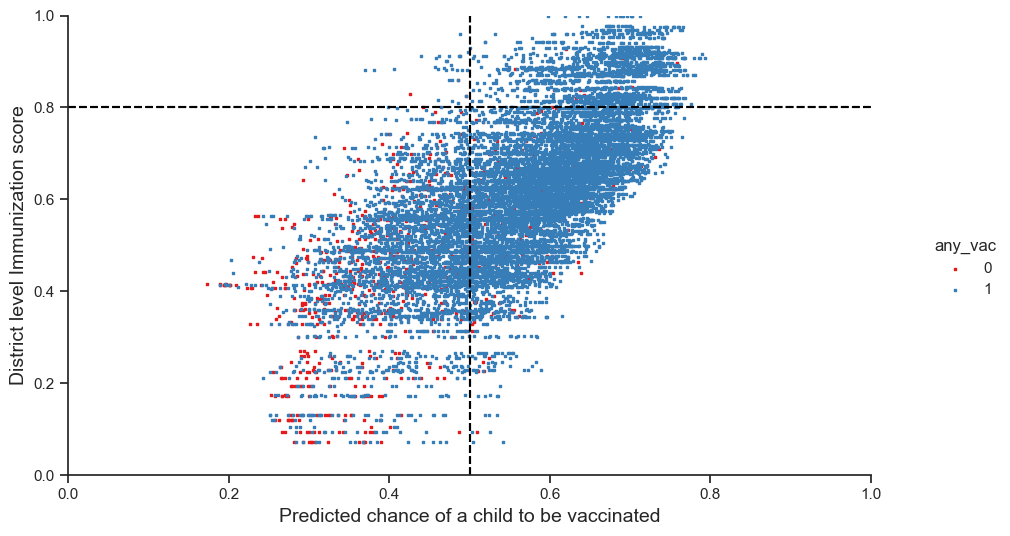

In [40]:
import seaborn as sns
sns.set(style='ticks')

country='IA2015'
df = read_file(country)
X= get_clean_dataset(country)
y=X['any_vac']
#X['v024'] = X['v024'].astype('category')
X = X.drop('any_vac', axis=1)
X = pd.merge(X, df['ia2015fic'], left_index=True, right_index=True)
X = pd.get_dummies(data=X, drop_first=True)
column_names = X.columns

X = encode_dataset(X)
y = encode_array(y) 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=26, test_size = 0.3)

df_full = pd.merge(X_test, df, left_index=True, right_index=True)
print(df_full.columns)
w = sum(y)/X.shape[0]
model = lm.RidgeClassifier(random_state=0, class_weight = {0:w, 1:1-w}, alpha = 0.00000001)
#model = lm.RidgeClassifier(class_weight = {0:1/(X.shape[0]-sum(y)), 1:1/sum(y)}, alpha = 0.00000001)
#model = lm.RidgeClassifier(class_weight = "balanced", alpha = 0.00000001)
model.fit(X_train, y_train)

pred = model.predict(X_test)
d = model.decision_function(X_test)
probs = 1/(1+np.exp(-d))#np.exp(d) / np.sum(np.exp(d))

df_full['scores'] = probs
df_full['pred'] = pred

color_labels = [0, 1]

plt.figure(figsize=(25,15))
plt.rcParams.update({'font.size': 28})

fg = sns.FacetGrid(data=df_full, hue='any_vac', hue_order=color_labels, aspect=1.61, palette='Set1', height=6)
fg.map(plt.scatter, 'scores', 'ia2015fic_y', s=1, marker='s').add_legend()
fg.set(xlim=(0.0, 1.0),ylim=(0.0, 1.0))
fg.set_axis_labels("Predicted chance of a child to be vaccinated", "District level Immunization score", fontsize=14)
fg.map(plt.axhline, y=0.8, ls='--', c='black')
fg.map(plt.axvline, x=0.5, ls='--', c='black')
fg.savefig('../results/Comparison_geotarget_vs_model/comparison_'+country+'.png', format = 'png', dpi=600, bbox_inches='tight')



In [41]:
#Number of unique districts
(df['sdist'].unique()).shape[0]

640

In [42]:
#Find specificity and sensitivity of the IMI_target rule
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
nkids = sum(df_full['IMI_target'])
n_left = df_full.shape[0] - nkids
df_full['IMI_not_target'] = 1-df_full['IMI_target']
nclusters_targeted = np.array((df_full[df_full['IMI_target']==1]['sdist']).unique()).shape[0]
roc = roc_auc_score(y_test, df_full['IMI_not_target'])
accuracy = accuracy_score(y_test, df_full['IMI_not_target'])
tn, fp, fn, tp = confusion_matrix(y_test, df_full['IMI_not_target']).ravel()
sensitivity = (tp / (tp + fn))
specificity = (tn / (tn + fp))
exclusion_error = (fp/(tn+fp))
inclusion_error = (fn/(fn+tn))
recall = tp/(tp+fn)
f1 = f1_score(y_test, df_full['IMI_not_target'])

results = {"tp": tp, "fp":fp, "fn":fn, "tn": tn, "roc": roc , "exclusion error": exclusion_error, "inclusion error": inclusion_error, "sensitivity" : sensitivity,
            "specificity": specificity, "f1":f1, "accuracy": accuracy, "nkids": nkids, "ndistricts": nclusters_targeted}
results['Method'] = 'IMI Target'
print('With IMI_target: ')
print(results)
results = pd.DataFrame([results])

for threshold in [0.5, 0.55, 0.6, 0.65, 0.7]:
    
    df_full['pred'] = np.where(probs >= threshold, 1, 0)
    nclusters_targeted = np.array((df_full[df_full['pred']==0]['sdist']).unique()).shape[0]
    nkids = df_full.shape[0]-sum(df_full['pred'])
    roc = roc_auc_score(y_test, df_full['pred'])
    accuracy = accuracy_score(y_test, df_full['pred'])
    tn, fp, fn, tp = confusion_matrix(y_test, df_full['pred']).ravel()

    sensitivity = (tp / (tp + fn))
    specificity = (tn / (tn + fp))
    recall = tp/(tp+fn)
    exclusion_error = (fp/(tn+fp))
    inclusion_error = (fn/(fn+tn))
    f1 = f1_score(y_test, df_full['pred'])

    results2 = {"tp": tp, "fp":fp, "fn":fn, "tn": tn, "roc": roc , "exclusion error": exclusion_error, "inclusion error": inclusion_error, "sensitivity" : sensitivity,
                "specificity": specificity, "f1":f1, "accuracy": accuracy, "nkids": nkids, "ndistricts": nclusters_targeted}
    print('With Ridge Model ('+str(threshold)+'): ')
    print(results2)
    results_df2 = pd.DataFrame([results2])
    results_df2['Method'] = 'Ridge Model ('+str(threshold)+')'
    results = pd.concat([results, results_df2], ignore_index = True)


threshold = np.partition(probs.flatten(), -n_left)[-n_left]
df_full['pred'] = np.where(probs >= threshold, 1, 0)
nclusters_targeted = np.array((df_full[df_full['pred']==0]['sdist']).unique()).shape[0]
nkids = df_full.shape[0]-sum(df_full['pred'])
roc = roc_auc_score(y_test, df_full['pred'])
accuracy = accuracy_score(y_test, df_full['pred'])
tn, fp, fn, tp = confusion_matrix(y_test, df_full['pred']).ravel()

sensitivity = (tp / (tp + fn))
specificity = (tn / (tn + fp))
recall = tp/(tp+fn)
exclusion_error = (fp/(tn+fp)) # Number of "not targeted" kids among all ZD
inclusion_error = (fn/(fn+tn)) # NUmber of non-ZD kids among all who are targeted
f1 = f1_score(y_test, df_full['pred'])

results2 = {"tp": tp, "fp":fp, "fn":fn, "tn": tn, "roc": roc , "exclusion error": exclusion_error, "inclusion error": inclusion_error, "sensitivity" : sensitivity,
            "specificity": specificity, "f1":f1, "accuracy": accuracy, "nkids": nkids, "ndistricts": nclusters_targeted}
print('With Ridge Model ('+str(threshold)+'): ')
print(results2)
results_df2 = pd.DataFrame([results2])
results_df2['Method'] = 'Ridge Model (targeting '+str(nkids)+'), threshold='+str(threshold)
results = pd.concat([results, results_df2], ignore_index = True)

results.to_csv('../results/Comparison_geotarget_vs_model/comparison_metrics_'+country+'.csv', index=False)


With IMI_target: 
{'tp': 1839, 'fp': 31, 'fn': 11050, 'tn': 874, 'roc': 0.5542128304190176, 'exclusion error': 0.03425414364640884, 'inclusion error': 0.9267024488426703, 'sensitivity': 0.1426798044844441, 'specificity': 0.9657458563535911, 'f1': 0.24920387560132798, 'accuracy': 0.1966797158184718, 'nkids': 11924, 'ndistricts': 527, 'Method': 'IMI Target'}
With Ridge Model (0.5): 
{'tp': 9637, 'fp': 275, 'fn': 3252, 'tn': 630, 'roc': 0.7219122134639628, 'exclusion error': 0.30386740331491713, 'inclusion error': 0.8377125193199382, 'sensitivity': 0.7476918302428427, 'specificity': 0.6961325966850829, 'f1': 0.845313802026227, 'accuracy': 0.744309119907206, 'nkids': 3882, 'ndistricts': 442}
With Ridge Model (0.55): 
{'tp': 7830, 'fp': 178, 'fn': 5059, 'tn': 727, 'roc': 0.7054048400516265, 'exclusion error': 0.19668508287292819, 'inclusion error': 0.8743518838575873, 'sensitivity': 0.6074947629761812, 'specificity': 0.8033149171270718, 'f1': 0.7493898645738623, 'accuracy': 0.62034217775844

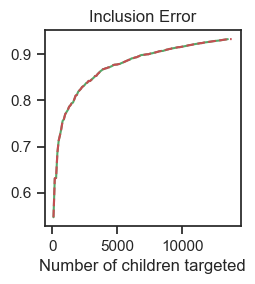

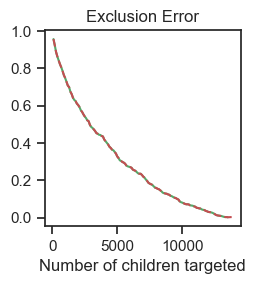

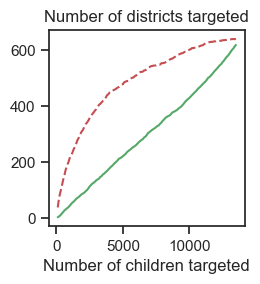

In [43]:
#Find specificity and sensitivity of the IMI_target rule for change in threshold
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

desired_labels = np.arange(100, df_full.shape[0]-200, 100)
IMI_incl = []
IMI_excl = []
model_incl = []
model_excl = []
nclusters_targeted_IMI = []
nclusters_targeted_model = []
for i in desired_labels:
    nkids = i
    n_left = df_full.shape[0]-nkids
    threshold = np.partition(np.array(df_full['ia2015fic_y']).flatten(), -n_left)[-n_left]
    df_full['IMI_not_target'] = np.where(df_full['ia2015fic_y'] >= threshold, 1, 0)
    
    nclusters_targeted = np.array((df_full[df_full['IMI_not_target']==0]['sdist']).unique()).shape[0]
    nclusters_targeted_IMI = np.append(nclusters_targeted_IMI, nclusters_targeted)
    
    tn, fp, fn, tp = confusion_matrix(y_test, df_full['IMI_not_target']).ravel()
    exclusion_error = (fp/(tn+fp))
    inclusion_error = (fn/(fn+tn))
    IMI_incl = np.append(IMI_incl, inclusion_error)
    IMI_excl = np.append(IMI_excl, exclusion_error)


    threshold = np.partition(probs.flatten(), -n_left)[-n_left]
    df_full['pred'] = np.where(probs >= threshold, 1, 0)

    nclusters_targeted = np.array((df_full[df_full['pred']==0]['sdist']).unique()).shape[0]
    nclusters_targeted_model = np.append(nclusters_targeted_model, nclusters_targeted)
    
    tn, fp, fn, tp = confusion_matrix(y_test, df_full['pred']).ravel()
    exclusion_error = (fp/(tn+fp))
    inclusion_error = (fn/(fn+tn))
    model_incl = np.append(IMI_incl, inclusion_error)
    model_excl = np.append(IMI_excl, exclusion_error)
    
desired_labels2 = np.append(desired_labels, df_full.shape[0])
plt.plot(desired_labels, IMI_incl, 'g', ls='-')
plt.plot(desired_labels2, model_incl, 'r', ls = '--')
plt.title('Inclusion Error')
plt.xlabel('Number of children targeted')
plt.savefig('../results/Comparison_geotarget_vs_model/inclusion_error_'+country+'.png', format = 'png', dpi=600, bbox_inches='tight')
plt.show()

plt.plot(desired_labels, IMI_excl, 'g', ls='-')
plt.plot(desired_labels2, model_excl, 'r', ls = '--')
plt.title('Exclusion Error')
plt.xlabel('Number of children targeted')
plt.savefig('../results/Comparison_geotarget_vs_model/exclusion_error'+country+'.png', format = 'png', dpi=600, bbox_inches='tight')
plt.show()

plt.plot(desired_labels, nclusters_targeted_IMI, 'g', ls='-')
plt.plot(desired_labels, nclusters_targeted_model, 'r', ls = '--')
plt.title('Number of districts targeted')
plt.xlabel('Number of children targeted')
plt.savefig('../results/Comparison_geotarget_vs_model/districts_'+country+'.png', format = 'png', dpi=600, bbox_inches='tight')
plt.show()


In [44]:
#Distribution of vaccines per coverage decile
bins = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
results_all= pd.DataFrame()
for bin in bins:
    df_cut = df_full[np.logical_and(np.array(df_full['ia2015fic_y']>=(bin-0.1)) , np.array(df_full['ia2015fic_y']<(bin)))] 
    no_vac = np.mean(df_cut['any_vac']==0)
    all_vac = np.mean(df_cut['all_vac']==1)
    partial_vac = 1-no_vac-all_vac
    nkids = df_cut.shape[0]
    nZDkids = df_cut[df_cut['any_vac']==0].shape[0]
    nclusters = df_cut['sdist'].unique().shape[0]
    res ={"low": (bin-0.1), "high": bin, "no_vac": no_vac, "partial_vac":partial_vac, "all_vac":all_vac, "nZDkids": nZDkids, "ndistricts": nclusters, "nkids": nkids}
    res_df = pd.DataFrame([res])
    results_all =  pd.concat([results_all, res_df], ignore_index = True)
print(results_all)
results_all.to_csv('../results/Comparison_geotarget_vs_model/ia2015fic_levels_'+country+'.csv', index=False)


   low  high    no_vac  partial_vac   all_vac  nZDkids  ndistricts  nkids
0  0.0   0.1  0.456140     0.456140  0.087719       26           2     57
1  0.1   0.2  0.344156     0.493506  0.162338       53           6    154
2  0.2   0.3  0.237500     0.500000  0.262500       57          12    240
3  0.3   0.4  0.169291     0.486877  0.343832      129          37    762
4  0.4   0.5  0.097991     0.448134  0.453875      239         106   2439
5  0.5   0.6  0.065934     0.370487  0.563579      168         109   2548
6  0.6   0.7  0.042826     0.309329  0.647845      157         152   3666
7  0.7   0.8  0.021866     0.231293  0.746842       45         103   2058
8  0.8   0.9  0.021226     0.130503  0.848270       27          74   1272
9  0.9   1.0  0.006849     0.053082  0.940068        4          38    584


In [20]:
#Increase cost-sensitive weights and observe the model's behavior

def graph_metrics_versus_weight(country, amt_points):
    plt.figure(figsize=(5,4))
    plt.rcParams.update({'font.size': 28})
    accuracy_scores = []  
    specificity_scores = []
    sensitivity_scores = []
    f1_scores = []
    df = read_file(country)
    X=df.drop(['clusterid', 'v024', 'all_vac'], axis=1) 
    X['regionname']=X['regionname'].astype('category')
    if country=='IA2015':
        X=X.drop(['sdist', 'ia2015fic', 'IMI_target'], axis=1)   
    if country=='IA2020':
        X=X.drop(['sdist'], axis=1)     
    X = X.dropna()
    y=X['any_vac']
    X = X.drop('any_vac', axis=1)
    #X['v024'] = X['v024'].astype('category')
    X = pd.get_dummies(data=X, drop_first=True)
    print(X.values[X.isna()])
    column_names = X.columns
    X = encode_dataset(X)
    y = encode_array(y) 
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size = 0.3)

       
    zero_weights = np.arange(1,amt_points/2)
    zero_weights = 0.5 + (zero_weights /amt_points)
   
    for i in zero_weights:
    #     Hyperparams that do best with this dataset 
        model = lm.RidgeClassifier(random_state=0, alpha = 0.00000001, class_weight = {0:i, 1:1-i})


        model.fit(X_train,y_train)

    #         Now, let's see how the model does on the test data

        ypred = model.predict(X_test)


        accuracy = accuracy_score(y_test, ypred)
        tn, fp, fn, tp = confusion_matrix(y_test, ypred).ravel()
        sensitivity = (tp / (tp + fn))
        specificity = (tn / (tn + fp))
        f1score = f1_score(y_test, ypred)
        f1_scores.append(f1score)
        accuracy_scores.append(accuracy)
        sensitivity_scores.append(sensitivity)
        specificity_scores.append(specificity)
    frac_ratio = np.mean(y_train)
    plt.title('Comparison of Ridge Regression performance with increase in penalty on misclassifying ZD a child ('+country+')')
    plt.xlabel('Proportional cost')
    #plt.ylabel('Metric Value')
    plt.style.use('_mpl-gallery')
    plt.plot(zero_weights , sensitivity_scores, label = "sensitivity")
    plt.plot(zero_weights, specificity_scores, label = "specificity")
    #plt.plot(zero_weights, accuracy_scores, label = "accuracy")    
    plt.plot(zero_weights, f1_scores, label = "F1 score", color = "purple")
    plt.axvline(x = frac_ratio, color = 'black', ls='--', label = 'fraction of non-ZD children')
    plt.legend()
    plt.savefig('../results/Model_outcomes/changing_penalty_'+country+'.png', format = 'png', dpi=600, bbox_inches='tight')  
    plt.show()


[]


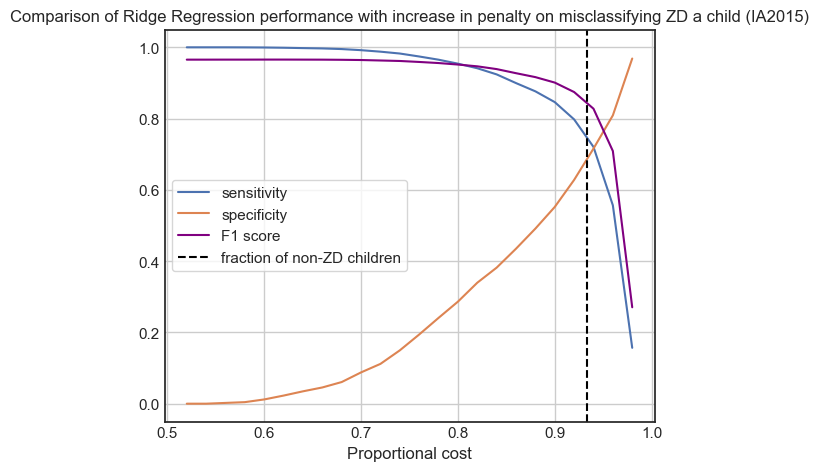

In [21]:
graph_metrics_versus_weight("IA2015", 50)